# Evaluation methods in NLP

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2019"

## Contents

1. [Overview](#Overview)
1. [Your projects](#Your-projects)
1. [Set-up](#Set-up)
1. [Data organization](#Data-organization)
  1. [Train/dev/test](#Train/dev/test)
  1. [No fixed splits](#No-fixed-splits)
1. [Cross-validation](#Cross-validation)
  1. [Random splits](#Random-splits)
  1. [K-folds](#K-folds)
1. [Baselines](#Baselines)
  1. [Baselines are crucial for strong experiments](#Baselines-are-crucial-for-strong-experiments)
  1. [Random baselines](#Random-baselines)
  1. [Task-specific baselines](#Task-specific-baselines)
1. [Hyperparameter optimization](#Hyperparameter-optimization)
  1. [Rationale](#Rationale)
  1. [The ideal hyperparameter optimization setting](#The-ideal-hyperparameter-optimization-setting)
  1. [Practical considerations, and some compromises](#Practical-considerations,-and-some-compromises)
  1. [Hyperparameter optimization tools](#Hyperparameter-optimization-tools)
1. [Classifier comparison](#Classifier-comparison)
  1. [Practical differences](#Practical-differences)
  1. [Confidence intervals](#Confidence-intervals)
  1. [Wilcoxon signed-rank test](#Wilcoxon-signed-rank-test)
  1. [McNemar's test](#McNemar's-test)
1. [Assessing models without convergence](#Assessing-models-without-convergence)
  1. [Incremental dev set testing](#Incremental-dev-set-testing)
  1. [Early stopping](#Early-stopping)
  1. [Learning curves with confidence intervals](#Learning-curves-with-confidence-intervals)
1. [The role of random parameter initialization](#The-role-of-random-parameter-initialization)
1. [Closing remarks](#Closing-remarks)

## Overview

This notebook is an overview of experimental methods for NLU. My primary goal is to help you with the experiments you'll be doing for your projects.  It is a companion to [the evaluation metrics notebook](evaluation_metrics.ipynb), which I suggest studying first.

The teaching team will be paying special attention to how you conduct your evaluations, so this notebook should create common ground around what our values are.

This notebook is far from comprehensive. I hope it covers the most common tools, techniques, and challenges in the field. Beyond that, I'm hoping the examples here suggest a perspective on experiments and evaluations that generalizes to other topics and techniques.

## Your projects

1. We will never evaluate a project based on how "good" the results are.
  1. Publication venues do this, because they have additional constraints on space that lead them to favor positive evidence for new developments over negative results.
  1. In CS224u, we are not subject to this constraint, so we can do the right and good thing of valuing positive results, negative results, and everything in between.

1. We __will__ evaluate your project on:   
  1. The appropriateness of the metrics
  1. The strength of the methods
  1. The extent to which the paper is open and clear-sighted about the limits of its findings. 

## Set-up

In [2]:
%matplotlib inline
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier
import utils

## Data organization

### Train/dev/test

Many publicly available datasets are released with a train/dev/test structure. __We're all on the honor system to do test-set runs only when development is complete.__

Splits like this basically presuppose a fairly large dataset.

If there is no dev set as part of the distribution, then you might create one to simulate what a test run will be like, though you have to weigh this against the reduction in train-set size.

Having a fixed test set ensures that all systems are assessed against the same gold data. This is generally good, but it is problematic where the test set turns out to have unusual properties that distort progress on the task.

### No fixed splits

Many datasets are released without predefined splits. This poses challenges for assessment, especially comparative assessment: __for robust comparisons with prior work, you really have to rerun the models using your assessment regime on your splits__. For example, if you're doing [5-fold cross-validation](#K-folds), then all the systems should be trained and assessed using exactly the same folds, to control for variation in how difficult the splits are.

If the dataset is large enough, you might create a train/test or train/dev/test split right at the start of your project and use it for all your experiments. This means putting the test portion in a locked box until the very end, when you assess all the relevant systems against it. For large datasets, this will certainly simplify your experimental set-up, for reasons that will become clear when we discuss [hyperparameter optimization](#Hyperparameter-optimization) below.

For small datasets, carving out dev and test sets might leave you with too little data. The most problematic symptom of this is that performance is highly variable because there isn't enough data to optimize reliably. In such situations, you might give up on having fixed splits, opting instead for some form of cross-validation, which allows you to average over multiple runs.

## Cross-validation

In cross-validation, we take a set of examples $X$ and partition them into two or more train/test splits, and then we average over the results in some way.

### Random splits

When creating random train/test splits, we shuffle the examples and split them, with a pre-specified percentage $t$ used for training and another pre-specified percentage (usually $1-t$) used for testing.

In general, we want these splits to be __stratified__ in the sense that the train and test splits have approximately the same distribution over the classes.

#### The good and the bad of random splits

A nice thing about random splits is that you can create as many as you want without having this impact the ratio of training to testing examples. 

This can also be a liability, though, as there's no guarantee that every example will be used the same number of times for training and testing. In principle, one might even evaluate on the same split more than once (though this will be fantastically unlikely for large datasets).

#### Random splits in scikit-learn

In scikit-learn, the function [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) will do random splits. It is a wrapper around [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) or [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit), depending on how the keyword argument `stratify` is used. A potential gotcha for classification problems: `train_test_split` does not stratify its splits by default, whereas stratified splits are desired in most situations.

### K-folds

In K-fold cross-validation, one divides the data into $k$ folds of equal size and then conducts $k$ experiments. In each, fold $i$ is used for assessment, and all the other folds are merged together for training:

$$
\begin{array}{c c c }
\textbf{Splits} & \textbf{Experiment 1} & \textbf{Experiment 2} & \textbf{Experiment 3} \\
\begin{array}{|c|}
\hline
\textrm{fold } 1  \\\hline
\textrm{fold } 2  \\\hline
\textrm{fold } 3  \\\hline
\end{array}
& 
\begin{array}{|c c|}
\hline
\textbf{Test} & \textrm{fold } 1  \\\hline
\textbf{Train} & \textrm{fold } 2  \\
& \textrm{fold } 3  \\\hline
\end{array}
&
\begin{array}{|c c|}
\hline
\textbf{Test} & \textrm{fold } 2  \\\hline
\textbf{Train} & \textrm{fold } 1  \\
& \textrm{fold } 3  \\\hline
\end{array}
&
\begin{array}{|c c|}
\hline
\textbf{Test} & \textrm{fold } 3  \\\hline
\textbf{Train} & \textrm{fold } 1  \\
& \textrm{fold } 2  \\\hline
\end{array}
\end{array}
$$

#### The good and the bad of k-folds

* With k-folds, every example appears in a train set exactly $k-1$ times and in a test set exactly once. We noted above that random splits do not guarantee this.

* A major drawback of k-folds is that the size of $k$ determines the size of the train/test splits. With 3-fold cross validation, one trains on 67% of the data and tests on 33%. With 10-fold cross-validation, one trains on 90% and tests on 10%. These are likely to be __very__ different experimental scenarios. This is a consideration one should have in mind when [comparing models](#Classifier-comparison) using statistical tests that depend on repeated runs.

#### K-folds in scikit-learn

* In scikit-learn, [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) and [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) are the primary classes for creating k-folds from a dataset. As with random splits, the stratified option is recommended for most classification problems, as one generally want to train and assess with the same label distribution.

* The methods [cross_validate](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) and [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) are convenience methods that let you pass in a model (`estimator`), a dataset (`X` and `y`), and some cross-validation parameters, and they handle the repeated assessments. These are great. Two tips:
  * I strongly recommend passing in a `KFold` or `StratifiedKFold` instance as the value of `cv` to ensure that you get the split behavior that you desire.
  * Check that `scoring` has the value that you desire. For example, if you are going to report F1-scores, it's a mistake to leave `scoring=None`, as this will default to whatever your model reports with its `score` method, which is probably accuracy.
  

#### Variants  
  
K-folds has a number of variants and special cases. Two that frequently arise in NLU:

1. [LeaveOneOut](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) is the special case where the number of folds equals the number of examples. This is especially useful for very small datasets.

1. [LeavePGroupsOut](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePGroupsOut.html#sklearn.model_selection.LeavePGroupsOut) creates folds based on criteria that you define. This is useful in situations where the datasets have important structure that the splits need to respect – e.g., you want to assess against a graph sub-network that is never seen on training.

## Baselines

Evaluation numbers in NLP (and throughout AI) __can never be understood properly in isolation__:

* If your system gets 0.95 F1, that might seem great in absolute terms, but your readers will suspect the task is too easy and want to know what simple models achieve.

* If your system gets 0.60 F1, you might despair, but it could turn out that humans achieve only 0.80, indicating that you got traction on a very challenging but basically coherent problem.

### Baselines are crucial for strong experiments

Defining baselines should not be an afterthought, but rather central to how you define your overall hypotheses. __Baselines are essential to building a persuasive case__, and they can also be used to illuminate specific aspects of the problem and specific virtues of your proposed system.

### Random baselines

Random baselines are almost always useful to include. scikit-learn has classes [DummyClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier) and [DummyRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor) that make it easy to include these baselines in your workflow. Each of them has a keyword argument `strategy` that allows you to specify a range of different styles of random guessing.

### Task-specific baselines

It is worth considering whether your problem suggests a baseline that will reveal something about the problem or the ways it is modeled. Two recent examples from NLU:

1. As disussed briefly in [the NLI models notebook](nli_02_models.ipynb#Other-findings), [Leonid Keselman](https://leonidk.com/) observed [in his 2016 NLU course project](https://leonidk.com/stanford/cs224u.html) that one can do much better than chance on SNLI by processing only the hypothesis, ignoring the premise entirely. The exact interpretation of this is complex (we'll explore this a bit [in our NLI bake-off](http://nbviewer.jupyter.org/github/cgpotts/cs224u/blob/master/nli_wordentail_bakeoff.ipynb)), but it's certainly relevant for understanding how much a system has actually learned about reasoning from a premise to a conclusion.
 
1. [Schwartz et al. (2017)](https://aclanthology.coli.uni-saarland.de/papers/W17-0907/w17-0907) develop a system for choosing between a coherent and incoherent ending for a story. Their best system achieves 75% accuracy by processing the story and the ending, but they achieve 72% using only stylistic features of the ending, ignoring the preceding story entirely. This puts the 75% – and the extent to which the system understands story completion – in a new light.

## Hyperparameter optimization

In machine learning, the __parameters__ of a model are those whose values are learned as part of optimizing the model itself. 

The __hyperparameters__ of a model are any settings that are set by a process that is outside of this optimization process. The boundary between a true setting of the model and a broader design choice will likely be blurry conceptually. For example: 

* The regularization term for a classifier is a clear hyperparameter – it appears in the model's objective function. 
* What about the method one uses for normalizing the feature values? This is probably not a setting of the model per se, but rather a choice point in your experimental framework.
  
For the purposes of this discussion, we'll construe hyperparameters very broadly.

### Rationale

Hyperparameter optimization is one of the most important parts machine learning, and a crucial part of building a persuasive argument. To see why, it's helpful to imagine that you're in an ongoing debate with a very skeptical referee:

1. You ran experiments with models A, B, and C. For each, you used the default hyperparameters as given by the implementations you're using. You found that C performed the best, and so you reported that in your paper.
1. Your reviewer doesn't have visibility into your process, and maybe doesn't fully trust you. Did you try any other values for the hyperparameters without reporting that? If not, would you have done that if C hadn't outperformed the others? There is no way for the reviewer (or perhaps anyone) to answer these questions.
1. So, from the reviewer's perspective, all we learned from your experiments is that there is some set of hyperparameters on which C wins this competition. But, strictly speaking, this conveys no new information; we knew before you did your experiments that we could find settings that would deliver this and all other outcomes. (They might not be __sensible__ settings, but remember you're dealing with a hard-bitten, unwavering skeptic.)

Our best response to this situation is to allow these models to explore a wide range of hyperparameters, choose the best ones according to performance on training or development data, and then report how they do with those settings at test time. __This gives every model its best chance to succeed.__

If you do this, the strongest argument that your skeptical reviewer can muster is that you didn't pick the right space of hyperparameters to explore for one or more of the models. Alas, there is no satisfying the skeptic, but we can at least feel happy that the outcome of these experiments will have a lot more scientific value than the ones described above with fixed hyperparameters.

### The ideal hyperparameter optimization setting

When evaluating a model, the ideal regime for hyperparameter optimization is as follows:

1. For each hyperparameter, identify a large set of values for it. 
2. Create a list of all the combinations of all the hyperparameter values. This will be the [cross-product](https://en.wikipedia.org/wiki/Cartesian_product) of all the values for all the features identified at step 1.
3. For each of the settings, cross-validate it on the available training data.
4. Choose the settings that did best in step 3, train on all the training data using those settings, and then evaluate that model on the test set.

This is very demanding. First, The number of settings grows quickly with the number of hyperparameters and values. If hyperparameter $h_{1}$ has $5$ values and hyperparameter $h_{2}$ has $10$, then the number of settings is $5 \cdot 10 = 50$. If we add a third hyperparameter $h_{3}$ with just $2$ values, then the number jumps to $100$. Second, if you're doing 5-fold cross-validation, then each model is trained 5 times. You're thus committed to training $500$ models.

And it could get worse. Suppose you don't have a fixed train/test split, and you're instead reporting, say, the result of 10 random train/test splits. Strictly speaking, the optimal hyperparameters could be different for different splits. Thus, for each split, the above cross-validation should be conducted. Now you're committed to training $5,000$ systems!

### Practical considerations, and some compromises

The above is untenable as a set of laws for the scientific community. If we adopted it, then complex models trained on large datasets would end up disfavored, and only the very wealthy would be able to participate. Here are some pragmatic steps you can take to alleviate this problem, in descending order of attractiveness. (That is, the lower you go on this list, the more likely the skeptic is to complain!)

1. [Bergstra and Bengio (2012)](http://www.jmlr.org/papers/v13/bergstra12a.html) argue that __randomly sampling__ from the space of hyperparameters delivers results like the full "grid search" described above with a relatively few number of samples. __Hyperparameter optimization algorithms__ like those implemented in [Hyperopt](http://hyperopt.github.io/hyperopt/) and [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) allow guided sampling from the full space. All these methods control the exponential growth in settings that comes from any serious look at one's hyperparameters. 

1. In large deep learning systems, __the hyperparameter search could be done on the basis of just a few iterations__. The systems likely won't have converged, but it's a solid working assumption that early performance is highly predictive of final performance. You might even be able to justify this with learning curves over these initial iterations.

1. Not all hyperparameters will contribute equally to outcomes. Via heuristic exploration, it is typically possible to __identify the less informative ones and set them by hand__. As long as this is justified in the paper, it shouldn't rile the skeptic too much.

1. Where repeated train/test splits are being run, one might __find optimal hyperparameters via a single split__ and use them for all the subsequent splits. This is justified if the splits are very similar.

1. In the worst case, one might have to adopt hyperparameters that were optimal for other experiments that have been published. The skeptic will complain that these findings don't translate to your new data sets. That's true, but it could be the only option. For example, how would one compare against [Rajkomar et al. (2018)](https://arxiv.org/abs/1801.07860) who report that "the performance of all above neural networks were [sic] tuned automatically using Google Vizier [35] with a total of >201,000 GPU hours"?

### Hyperparameter optimization tools

* scikit-learn's [model_selection](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) package has classes `GridSearchCV` and `RandomizedSearchCV`. These are very easy to use. (We used `GridSearchCV` in our sentiment unit.)

* [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) offers a variety of methods for guided search through the grid of hyperparameters. [This post](https://roamanalytics.com/2016/09/15/optimizing-the-hyperparameter-of-which-hyperparameter-optimizer-to-use/) assesses these methods against grid search and fully randomized search, and it also provides [starter code](https://github.com/roamanalytics/roamresearch/tree/master/BlogPosts/Hyperparameter_tuning_comparison) for using these implementations with sklearn-style classifiers.

## Classifier comparison

Suppose you've assessed two classifier models. Their performance is probably different to some degree. What can be done to establish whether these models are different in any meaningful sense?

### Practical differences

One very simple step one can take is to simply count up how many examples the models actually differ on. 

* If the test set has 1,000 examples, then a difference of 1% in accuracy or F1 will correspond to roughly 10 examples. We'll likely have intuitions about whether that difference has any practical import. 

* If the test set has 1M examples, then 1% will correspond to 10,000 examples, which seems sure to matter. Unless other considerations (e.g., cost, understandability) favor the less accurate model, the choice seems clear.

### Confidence intervals

If you can afford to run the model multiple times, then reporting confidence intervals based on the resulting scores could suffice to build an argument about whether the models are meaningfully different.

The following will calculate a simple 95% confidence interval for a vector of scores `vals`:

In [3]:
def get_ci(vals):
    if len(set(vals)) == 1:
        return (vals[0], vals[0])
    loc = np.mean(vals)
    scale = np.std(vals) / np.sqrt(len(vals))
    return stats.t.interval(0.95, len(vals)-1, loc=loc, scale=scale)

It's very likely that these confidence intervals will look very large relative to the variation that you actually observe. You probably can afford to do no more than 10–20 runs. Even if your model is performing very predictably over these runs (which it will, assuming your method for creating the splits is sound), the above intervals will be large in this situation. This might justify bootstrapping the confidence intervals. I recommend [scikits-bootstrap](https://github.com/cgevans/scikits-bootstrap) for this.

__Important__: when evaluating multiple systems via repeated train/test splits or cross-validation, all the systems have to be run on the same splits. This is the only way to ensure that all the systems face the same challenges.

### Wilcoxon signed-rank test

NLPers always choose tables over plots for some reason, and confidence intervals are hard to display in tables. This might mean that you want to calculate a p-value. 

Where you can afford to run the models at least 10 times with different splits (and preferably more like 20), [Demšar (2006)](http://www.jmlr.org/papers/v7/demsar06a.html) recommends the [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test). This is implemented in scipy as [scipy.stats.wilcoxon](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html). This test relies only on the absolute differences between scores for each split and makes no assumptions about how the scores are distributed.

Take care not to confuse this with [scipy.stats.ranksums](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html), which does the Wilcoxon rank-sums test. This is also known as the [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test), though SciPy distinguishes this as a separate test ([scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu)). In any case, the heart of this is that the signed-rank variant is more appropriate for classifier assessments, where we are always comparing systems trained and assessed on the same underlying pool of data.

Like all tests of this form, we should be aware of what they can tell us and what they can't: 

* The test says __nothing__ about the practical importance of any differences observed. 

* __Small p-values do not reliably indicate large effect sizes__. (A small p-value will more strongly reflect the number of samples you have.)

* Large p-values simply mean that the available evidence doesn't support a conclusion that the systems are different, not that there is no difference in fact. And even that limited conclusion is only relative to this particular, quite conservative test. 

All this is to say that these values should not be asked to stand on their own, but rather presented as part of a larger, evidence-driven argument.

### McNemar's test

[McNemar's test](https://en.wikipedia.org/wiki/McNemar%27s_test) operates directly on the vectors of predictions for the two models being compared. As such, it doesn't require repeated runs, which is good where optimization is expensive.

The basis for the test is a contingency table with the following form, for two models A and B:

$$\begin{array}{|c | c |}
\hline
\textrm{number of examples}        & \textrm{number of examples} \\
\textrm{where A and B are correct} & \textrm{where A is correct, B incorrect} 
\\\hline
\textrm{number of examples}        & \textrm{number of examples} \\
\textrm{where A is correct, B incorrect} & \textrm{where both A and B are incorrect} \\\hline
\end{array}$$

Following [Dietterich (1998)](http://sci2s.ugr.es/keel/pdf/algorithm/articulo/dietterich1998.pdf), let the above be abbreviated to

$$\begin{array}{|c | c |}
\hline
n_{11} & n_{10}
\\\hline
n_{01} & n_{00} \\
\hline
\end{array}$$

The null hypothesis tested is that the two models have the same error rate, i.e., that $n_{01} = n_{10}$. The test statistic is

$$
\frac{
    \left(|(n_{01} - n_{10}| - 1\right)^{2}
}{
    n_{01} + n_{10}
}$$

which has an approximately chi-squared distribution with 1 degree of freedom. 

An implementation is available in this repository: `utils.mcnemar`.

## Assessing models without convergence

When working with linear models, convergence issues rarely arise. Typically, the implementation has a fixed number of iterations it performs, or a threshold on the error, and the model stops when it reaches one of these points. We mostly don't reflect on this because of the speed and stability of these models.

With neural networks, convergence takes center stage. The models rarely converge, or they converge at different rates between runs, and their performance on the test data is often heavily dependent on these differences. Sometimes a model with a low final error turns out to be great, and sometimes it turns out to be worse than one that finished with a higher error. Who knows?!

### Incremental dev set testing

The key to addressing this uncertainty is to __regularly collect information about dev set performance as part of training__. For example, at every 100th iteration, one could make predictions on the dev set and store that vector of predictions, or just whatever assessment metric one is using. These assessments can provide direct information about how the model is doing on the actual task we care about, which will be a better indicator than the errors.

All the PyTorch models for this course accept keyword arguments `X_dev` and `dev_iter`. If these are specified, then the model is tested every `test_iter` iteration and the resulting predictions are stored in the class attribute `dev_predictions`. Here's an example:

First, an artificial classification dataset with a train/dev/test structure:

In [4]:
X, y = make_classification(class_sep=0.5, n_samples=5000, n_features=200)

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train)

Second, a shallow neural classifier trained with the requisite keyword arguments provided to `fit`:

In [5]:
dev_iter = 5 # Test increments.

model = TorchShallowNeuralClassifier(max_iter=100, hidden_dim=10)

_ = model.fit(X_train, y_train, X_dev=X_dev, dev_iter=dev_iter)

Finished epoch 100 of 100; error is 0.04936201777309179

Third, we can calculate our chosen evaluation metric for each of the incremental predictions:

In [6]:
dev_preds = sorted(model.dev_predictions.items())

scores = [utils.safe_macro_f1(y_dev, p) for i, p in dev_preds]

scores = pd.Series(scores)

scores.index *= dev_iter

Finally, we have a neat plot that tells us a lot about how training affects the model's performance:

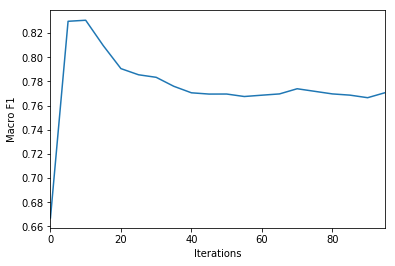

In [7]:
ax = scores.plot()
ax.set_xlabel("Iterations")
_ = ax.set_ylabel("Macro F1")

It's a different picture than we get from the error term:

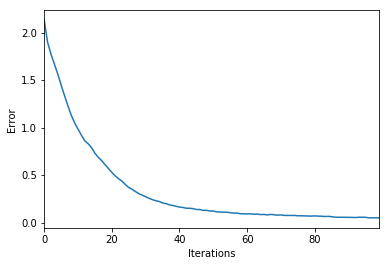

In [8]:
err_ax = pd.Series(model.errors).plot()
err_ax.set_xlabel("Iterations")
_ = err_ax.set_ylabel("Error")

### Early stopping

The above plot of dev-set performance suggests a simple strategy of __early stopping__: identify the iteration $i$ at which dev-set performance peaked and train our models for exactly $i$ iterations when doing our final test-set run. This value $i$ can be set differently for different models; selecting this point could even be done automatically during [hyperparameter](#Hyperparameter-optimization).

If it is important to test the same model that is being used to create the dev-set performance curve, then one needs to store all the model parameters for the currently best model and then "rewind" to that stage once one decides that further training isn't helping. This is arguably the safest thing to do, since it keeps the actual parameters that maximized dev-set performance; see below on [the impact of random initializations](#The-role-of-random-parameter-initialization).

For more on early stopping schemes, see [Prechelt 1997](http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf).

### Learning curves with confidence intervals

I frankly think the best response to all this is to accept that incremental performance plots like the above are how we should be assessing our models. This exposes all of the variation that we actually observe. 

In addition, in deep learning, we're often dealing with classes of models that are in principle capable of learning anything. The real question is implicitly how efficiently they can learn given the available data and other resources. Learning curves bring this our very clearly.

We can improve the curves by adding confidence intervals to them derived from repeated runs. Here's a plot from a paper I recently wrote with Nick Dingwall ([Dingwall and Potts 2018](https://arxiv.org/abs/1803.09901)):

<img src="fig/diagnosis-curve.png" />

I think this shows very clearly that, once all is said and done, the Mittens model (red) learns faster than the others, but is indistinguishable from the Clinical text GloVe model (blue) after enough training time. Furthermore, it's clear that the other two models are never going to catch up in the current experimental setting. A lot of this information would be lost if, for example, we decided to stop training when dev set performance reached its peak and report only a single F1 score per class.

## The role of random parameter initialization

Most deep learning models have their parameters initialized randomly, perhaps according to some heuristics related to the number of parameters ([Glorot and Bengio 2010](http://proceedings.mlr.press/v9/glorot10a.html)) or their internal structure ([Saxe et al. 2014](https://arxiv.org/abs/1312.6120)). This is meaningful largely because of the non-convex optimization problems that these models define, but it can impact simpler models that have multiple optimal solutions that still differ at test time. 

There is growing awareness that these random choices have serious consequences. For instance, [Reimers and Gurevych (2017)](https://aclanthology.coli.uni-saarland.de/papers/D17-1035/d17-1035) report that different initializations for neural sequence models can lead to statistically significant results, and they show that a number of recent systems are indistinguishable in terms of raw performance once this source of variation is taken into account.

This shouldn't surprise practitioners, who have long struggled with the question of what to do when a system experiences a catastrophic failure as a result of unlucky initialization. (I think the answer is to report this failure rate.)

The code snippet below lets you experience this phenomenon for yourself. The XOR logic operator, which is true just in case its two arguments have the same value, is famously not learnable by a linear classifier but within reach of a neural network with a single hidden layer and a non-linear activation function ([Rumelhart et al. 1986](https://www.nature.com/articles/323533a0)). But how consistently do such models actually learn XOR? No matter what settings you choose, you rarely if ever see perfect performance across multiple runs.

In [9]:
def xor_eval(n_trials=10):
    xor = [
        ([1.,1.], 1),
        ([1.,0.], 0),
        ([0.,1.], 0),
        ([0.,0.], 1)]
    X, y = zip(*xor)
    results = defaultdict(int)
    for trial in range(n_trials):
        model = TorchShallowNeuralClassifier(
            hidden_dim=2,
            max_iter=500,
            eta=0.01)
        model.fit(X, y)
        preds = tuple(model.predict(X))
        result = 'correct' if preds == y else 'incorrect'
        results[result] += 1
    return results

xor_eval(n_trials=10)

Finished epoch 500 of 500; error is 0.0151921808719635015

defaultdict(int, {'correct': 8, 'incorrect': 2})

For better or worse, the only response we have to this situation is to __report scores for multiple complete runs of a model with different randomly chosen initializations__. [Confidence intervals](#Confidence-intervals) and [statistical tests](#Wilcoxon-signed-rank-test) can be used to summarize the variation observed. If the evaluation regime already involves comparing the results of multiple train/test splits, then ensuring a new random initializing for each of those would seem sufficient.

Arguably, these observations are incompatible with evaluation regimes involving only a single train/test split, as in [McNemar's test](#McNemar's-test). However, [as discussed above](#Practical-considerations,-and-some-compromises), we have to be realistic. If multiple run aren't feasible, then a more heuristic argument will be needed to try to convince skeptics that the differences observed are larger than we would expect from just different random initializations.

## Closing remarks

We can summarize most of the above with a few key ideas:
    
1. Your evaluation should be based around a few systems that are related in ways that illuminate your hypotheses and help to convey what the best models are learning.

1. Every model you assess should be given its best chance to shine (but we need to be realistic about how many experiments this entails!).

1. The test set should play no role whatsoever in optimization or model selection. The best way to ensure this is to have the test set locked away until the final batch of experiments that will be reported in the paper, but this separation is simulated adequately by careful cross-validation set-ups.

1. Strive to base your model comparisons in multiple runs on the same splits. This is especially important for deep learning, where a single model can perform in very different ways on the same data, depending on the vagaries of optimization.